In [1]:
import cv2
import matplotlib.pyplot as plt
import tensorflow
import os
import pandas as pd
import numpy as np
import keras
import seaborn as sns

from utils import detect_circles, detect_rectangles
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

In [2]:
BASE_DIR = os.path.dirname(os.getcwd())
DATA_DIR = "test_data"
IMAGE_DIR = "test_images"

# Data Analysis

In [3]:
heros = open(os.path.join(BASE_DIR, DATA_DIR, "hero_names.txt"), "r").read().split("\n")

In [4]:
heros[:5]

['Draven', 'Evelynn', 'Ezreal', 'Fiora', 'Fizz']

In [5]:
print("Number of heros:", len(heros))

Number of heros: 65


In [6]:
labels = open(os.path.join(BASE_DIR, DATA_DIR, "test.txt"), "r").read().split("\n")

In [7]:
labels = [label for label in labels if label]

In [8]:
print("Number of records:", len(labels))

Number of records: 98


In [9]:
labels = list(map(lambda x: {
    "file_name": x.split("\t")[0],
    "hero_name": x.split("\t")[1]
} if x else {}, labels))

In [10]:
distributed = {}
for data in labels:
    distributed[data["hero_name"]] = distributed.get(data["hero_name"], 0) + 1

<Axes: >

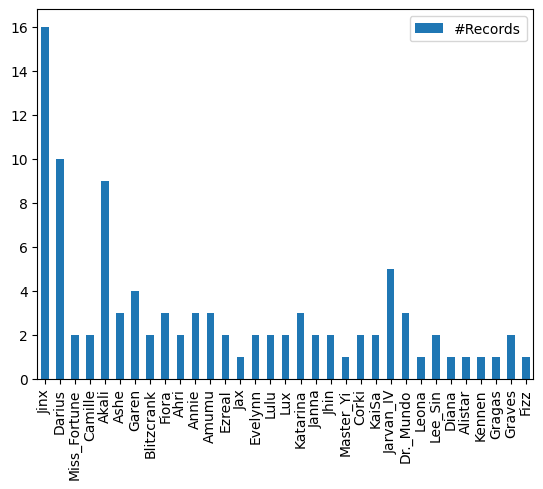

In [11]:
names = list(distributed.keys())
values = list(distributed.values())

# Create a sample dataframe with an text index
plotdata = pd.DataFrame(
    {"#Records": values}, 
    index=names)
# Plot a bar chart
plotdata.plot(kind="bar")

### Comment:
- There are some classes have amount of record more than others: Jinx, Darius, Akali, Javan
- There are some classes classes only have one record per class: Jax, Yi, Leona, Dianna, Alistar, Gragras, Fizz => Can cause missing data when split train, val, test
### Solution:
- Need to augmentation data. Because this is data from video so Rotation, Noise, Flip doesnt work in this scenario. And Images was already cropped, so  crop, scaling, translation doesnt work as well. In this exercise scenario, I will duplicate data to make data set have good distribution 

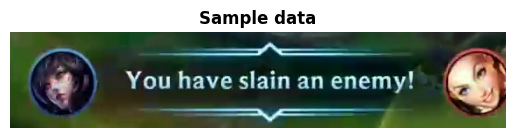

In [12]:
sample_img = "Ahri_278220660753197_round6_Ahri_06-02-2021.mp4_10_2.jpg"
sample_image_path = os.path.join(BASE_DIR, DATA_DIR, IMAGE_DIR, sample_img)

image = plt.imread(sample_image_path) 
  
fig, ax = plt.subplots() 
ax.imshow(image) 
ax.axis('off') 

plt.title('Sample data', fontweight ="bold") 
plt.show();

### Objectives:
- Need to get correct bounding box of hero to the left of image
### Solution:
- Divide the image in half, and use opencv to detect circle

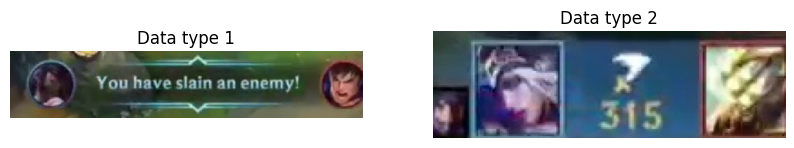

In [13]:
sample_img_1 = "Akali_JEpZIpnC-LM_round6_Akali_05-22-2021.mp4_10_1.jpg"
sample_img_2 = "Ashe_231705051716794_round3_Ashe_06-07-2021.mp4_26_2.jpg"

sample_image_path_1 = os.path.join(BASE_DIR, DATA_DIR, IMAGE_DIR, sample_img_1)
sample_image_path_2 = os.path.join(BASE_DIR, DATA_DIR, IMAGE_DIR, sample_img_2)

image_1 = plt.imread(sample_image_path_1) 
image_2 = plt.imread(sample_image_path_2) 
  
fig = plt.figure(figsize=(10, 7)) 

fig.add_subplot(1, 2, 1) 
plt.imshow(image_1)
plt.axis('off') 
plt.title("Data type 1")

fig.add_subplot(1, 2, 2) 
plt.imshow(image_2)
plt.axis('off') 
plt.title("Data type 2") 

plt.show();

## Problem
- Can not apply circle detection because we have 2 types of image (Circle and Rectangle)
- Can not apply object detection in this scenario because we dont have truth label and scope of this home exercise only 3 days
## Solution
- Need to apply simple approach to get circle or image in an image, and then get the biggest shape.

# Data processing

In [14]:
sample_image_path_1 = os.path.join(BASE_DIR, DATA_DIR, IMAGE_DIR, sample_img_1)

In [15]:
img = cv2.imread(sample_image_path_1)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = img_gray[:, :int(img_gray.shape[1]/2)]

In [16]:
ret, img_circle = detect_circles(img=img_gray)

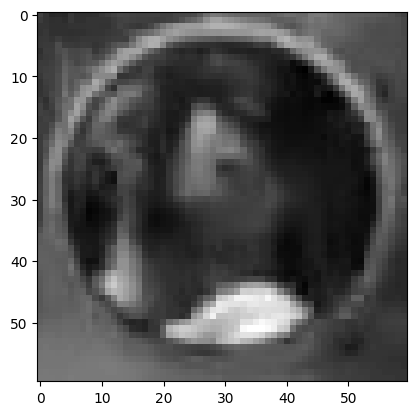

In [17]:
plt.imshow(img_circle, 'gray')

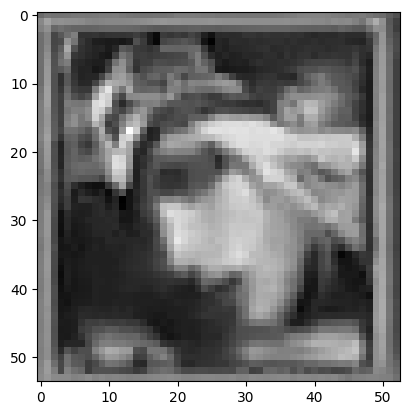

In [18]:
sample_image_path_2 = os.path.join(BASE_DIR, DATA_DIR, IMAGE_DIR, sample_img_2)
img = cv2.imread(sample_image_path_2)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = img_gray[:, :int(img_gray.shape[1]/2)]
ret, img_rectangle = detect_rectangles(img=img_gray)
plt.imshow(img_rectangle, 'gray')

In [19]:
class Dataset():
    def __init__(self, width=124, height=124, val_size=0.1, test_size=0.2):
        self.image_dir = os.path.join(BASE_DIR, DATA_DIR, IMAGE_DIR)
        self.label_dir = os.path.join(BASE_DIR, DATA_DIR, 'text.txt')
        self.hero_names_dir = os.path.join(BASE_DIR, DATA_DIR, 'hero_names.txt')
        
        self.val_size = val_size
        self.test_size = test_size
        self.height = height
        self.width = width
        
        self.idx2str = {}
        self.str2idx = {}
        
        self.X = []
        self.y = []
        
        self.X_train = []
        self.X_val = []
        self.X_test = []
        self.y_train = []
        self.y_val = []
        self.y_test = []
        
        
    def preprecessing_img(self, img):
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_gray = img_gray[:, :int(img_gray.shape[1]/2)]
        ret, img_circle = detect_circles(img=img_gray)
        if ret:
            x = img_circle
        else:
            ret, img_rectangle = detect_rectangles(img=img_gray)
            if ret:
                x = img_rectangle
            else:
                return False, None
        
        
        x = cv2.resize(x, (self.height, self.width), interpolation = cv2.INTER_LINEAR)
        return True, x
    
    def update_dicts(self, category):
        if category not in self.idx2str.values():
            index = len(self.idx2str)
            # Update vec2str dictionary
            self.idx2str[index] = category
            # Update str2vec dictionary
            self.str2idx[category] = index
            
    def equalize_class_distribution(self, X, y):
        X = np.array(X)
        y = np.array(y)
        class_counts = Counter(y)
        # average_samples_per_class = int(np.mean(list(class_counts.values())))
        average_samples_per_class = 10
        print(average_samples_per_class)

        X_equalized, y_equalized = [], []

        for class_label, count in class_counts.items():
            indices = np.where(np.array(y) == class_label)[0]
            if count < average_samples_per_class:
                # Duplicate data for the current class to meet the average
                indices_to_duplicate = np.random.choice(indices, size=average_samples_per_class - count, replace=True)
                indices = np.concatenate([indices, indices_to_duplicate])
            X_equalized.append(X[indices.tolist()])
            y_equalized.append(y[indices.tolist()])

        X_equalized = np.concatenate(X_equalized)
        y_equalized = np.concatenate(y_equalized)

        return X_equalized, y_equalized
    
    def one_hot_encoder(self):
        # Reshape the labels to a column vector (required by scikit-learn)
        y = self.y.reshape(-1, 1)

        # Initialize the OneHotEncoder
        encoder = OneHotEncoder(sparse=False)

        # Fit and transform the labels
        y_one_hot = encoder.fit_transform(y)
        return y_one_hot
    
    def train_test_split(self):
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(self.X, self.y, test_size=self.val_size+self.test_size, random_state=42)
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(X_temp, y_temp, test_size=self.test_size/(self.val_size+self.test_size), random_state=42)
        return True

        
    def load_dataset(self):
        data = open(os.path.join(BASE_DIR, DATA_DIR, "test.txt"), "r").read().split("\n") # Read txt file
        data = [x for x in data if x] # Remove empty string
        
        for record in data:
            file_name, hero_name = record.split("\t")
            img = cv2.imread(os.path.join(self.image_dir, file_name))
            ret, processed_img = self.preprecessing_img(img)
            if not ret:
                continue
            self.X.append(processed_img)
            self.y.append(hero_name)
        for category in self.y:
            self.update_dicts(category)
        self.y = list(map(lambda x: self.str2idx[x], self.y))
        
        self.X, self.y = self.equalize_class_distribution(self.X, self.y)
        self.X = np.expand_dims(self.X, axis=-1)
        self.X = self.X.astype('float32') / 255.0 # Normalize image
        self.y = self.one_hot_encoder()
        self.train_test_split()

In [20]:
dataset = Dataset()
dataset.load_dataset()

10


C:\Users\ACER\anaconda3\envs\gotoro\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [21]:
len(dataset.X)

300

In [22]:
len(dataset.X_train), len(dataset.X_val), len(dataset.X_test)

(209, 30, 61)

# Modelling

In context of this exercise, I will choose VGG16 to quickly solve problem

In [23]:
class Model():
    def __init__(self, num_class, threshold=0.5, batch_size=16, epochs=50, learning_rate=0.0001):
        self.num_class = num_class
        self.threshold = 0.5
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
    
    def set_architect(self):
        model = Sequential()
        model.add(Conv2D(input_shape=(124,124,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
        model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
        model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
        model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
        model.add(Flatten())
        model.add(Dense(units=4096,activation="relu"))
        model.add(Dense(units=1024,activation="relu"))
        model.add(Dense(units=self.num_class, activation="softmax"))
        self.model = model
    
    def compile_model(self):
        opt = Adam(lr=self.learning_rate)
        self.model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['acc'])
    
    def get_architecture(self):
        self.model.summary()
    
    def train(self, X_train, X_val, y_train, y_val):
        checkpoint = ModelCheckpoint("model/model.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
        history = self.model.fit(
            x=X_train,
            y=y_train,
            batch_size=self.batch_size,
            epochs=self.epochs,
            validation_data=[X_val, y_val],
            callbacks=[checkpoint, early]
        )
    def load_model(self, path="model/model.h5"):
        self.model = load_model(path)
    
    def predict(self, X):
        return self.model.predict(X)

In [24]:
num_class = dataset.y.shape[1]

In [25]:
num_class

30

In [26]:
model = Model(num_class=num_class)

In [42]:
model.set_architect()
model.compile_model()

C:\Users\ACER\anaconda3\envs\gotoro\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [43]:
model.get_architecture()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 124, 124, 64)      640       
                                                                 
 conv2d_14 (Conv2D)          (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 62, 62, 128)       73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 62, 62, 128)       147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 128)      0         
 2D)                                                  

In [44]:
dataset.X_train.shape

(209, 124, 124, 1)

Lulu


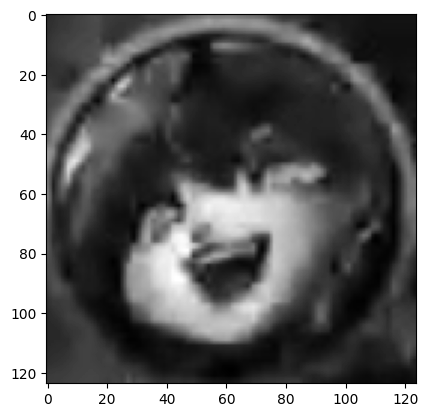

In [45]:
i = 40
index = np.argmax(dataset.y_train[i])
print(dataset.idx2str[index])
plt.imshow(dataset.X_train[i], 'gray')

In [46]:
model.train(dataset.X_train, dataset.X_val, dataset.y_train, dataset.y_val)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 3.4019 - acc: 0.0287
Epoch 1: val_acc improved from -inf to 0.00000, saving model to model\model.h5
14/14 [==============================] - 5s 313ms/step - loss: 3.4019 - acc: 0.0287 - val_loss: 3.4039 - val_acc: 0.0000e+00
Epoch 2/50
13/14 [==========================>...] - ETA: 0s - loss: 3.3803 - acc: 0.0385
Epoch 2: val_acc did not improve from 0.00000
14/14 [==============================] - 2s 115ms/step - loss: 3.3773 - acc: 0.0383 - val_loss: 3.6646 - val_acc: 0.0000e+00
Epoch 3/50
13/14 [==========================>...] - ETA: 0s - loss: 3.3007 - acc: 0.0433
Epoch 3: val_acc improved from 0.00000 to 0.13333, saving model to model\model.h5
14/14 [==============================] - 2s 158ms/step - loss: 3.3011 - acc: 0.0478 - val_loss: 3.4000 - val_acc: 0.1333
Epoch 4/50
13/14 [==========================>...] - ETA: 0s - loss: 3.3433 - acc: 0.1442
Epoch 4: val_acc did not improve from 0.13333
14/14 [=============

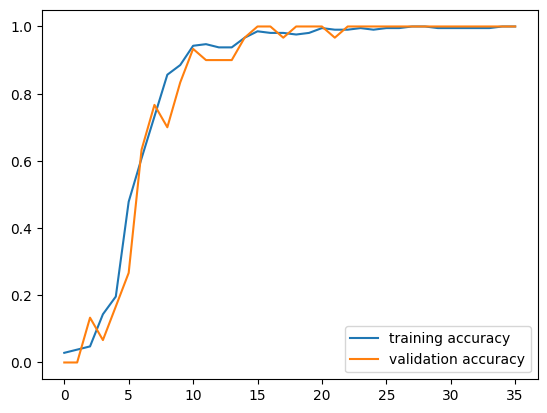

In [49]:
plt.plot(model.model.history.history["acc"], label="training accuracy")
plt.plot(model.model.history.history["val_acc"], label="validation accuracy")
plt.legend()
plt.show()


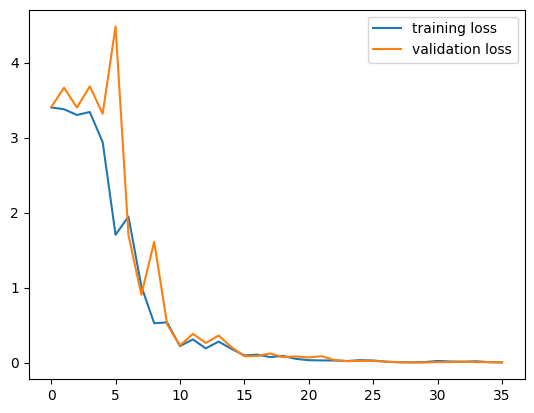

In [50]:
plt.plot(model.model.history.history["loss"], label="training loss")
plt.plot(model.model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()


Comment: <br>
    - The plot of training loss decreases to a point of stability. <br>
    - The plot of validation loss decreases to a point of stability and has a small gap with the training loss. <br>
=> Good fit

# Evaluation

In [27]:
model.load_model()

In [28]:
evaluation_result = model.model.evaluate(dataset.X_test, dataset.y_test)

2/2 [==============================] - 7s 2s/step - loss: 0.5280 - acc: 0.9344


In [29]:
evaluation_result

[0.5280085206031799, 0.9344262480735779]

In [30]:
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

Test Loss: 0.5280085206031799
Test Accuracy: 0.9344262480735779


In [31]:
y_pred = model.predict(dataset.X_test)

2/2 [==============================] - 0s 47ms/step


In [32]:
predicted_classes = np.argmax(y_pred, axis=1)

In [33]:
y_test_classes = np.argmax(dataset.y_test, axis=1)

In [34]:
precision = precision_score(y_test_classes, predicted_classes, average='micro')
recall = recall_score(y_test_classes, predicted_classes, average='micro')
f1 = f1_score(y_test_classes, predicted_classes, average='micro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9344262295081968
Recall: 0.9344262295081968
F1 Score: 0.9344262295081968


In [35]:
cm = confusion_matrix(y_test_classes, predicted_classes)

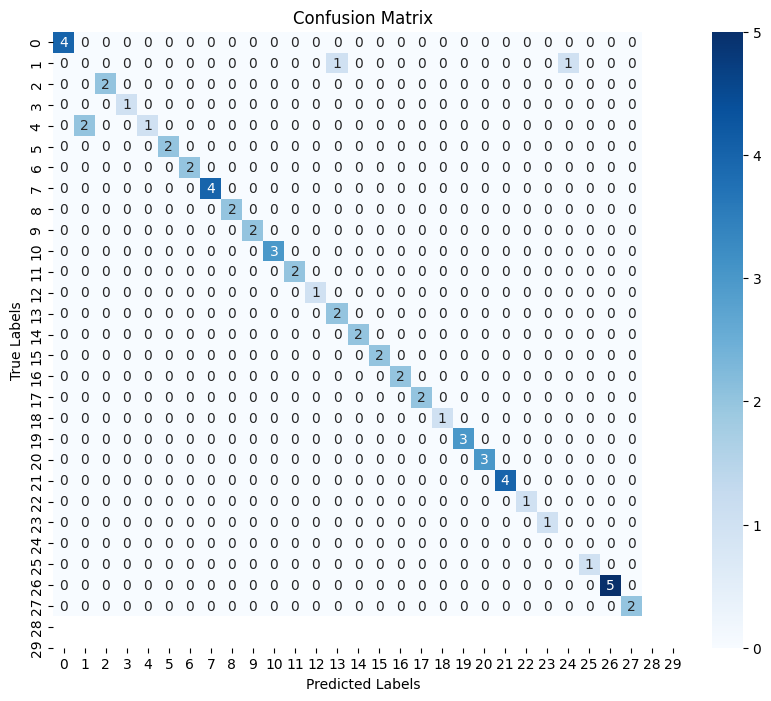

In [36]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_class), yticklabels=range(num_class))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Error Analysis

In [41]:
dataset.idx2str[1], dataset.idx2str[4] 

('Jinx', 'Garen')

Based on confusion matrix, we have error with classes 1 (Jinx) and 4 (Garen). Let's analysis it

In [38]:
misclassified_indices = np.where(predicted_classes != y_test_classes)[0]

In [39]:
misclassified_indices

array([ 3, 23, 43, 49], dtype=int64)

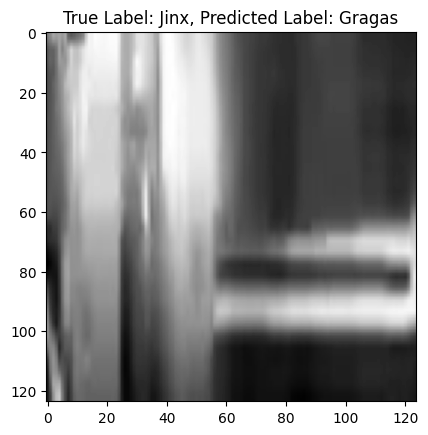

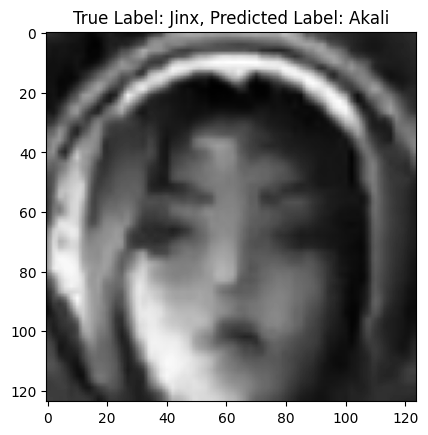

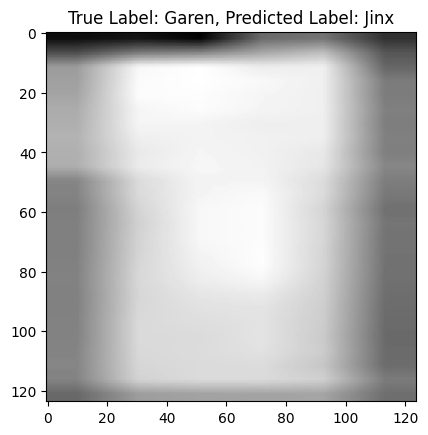

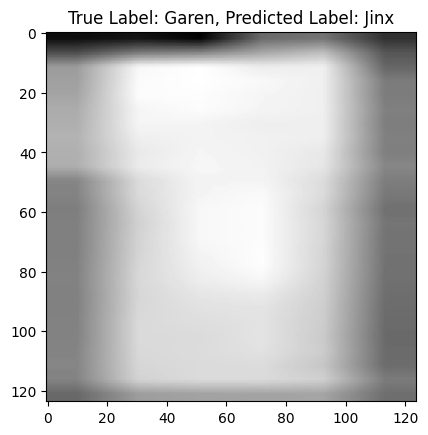

In [40]:
# Assuming X_test is your test data
for idx in misclassified_indices:  # Display the first 10 misclassifications
    plt.imshow(dataset.X_test[idx], cmap='gray')  # Adjust the cmap based on your data
    plt.title(f"True Label: {dataset.idx2str[y_test_classes[idx]]}, Predicted Label: {dataset.idx2str[predicted_classes[idx]]}")
    plt.show()

There are 2 type of error:
- Preprocessing error: Because we have some error on processing image, so it crop wrong image => Need to optimize processing pipeline
- Model error: Based on error visualization, we can see truth value is Jinx, and predicted value is Akali. But that image is Irelia. And after checked Jinx class, I see some error (wrong label) on this class => Need to relabel this class 

# Conclusion

In context of this excersise, I did  analyis data, processing image, modeling (did minor finetune on VGG-16), evaluation and analysis error

I did this exercise as POC, so there are some parts can be optimized, and missing some parts in a real ML project

Optimization: <br>
    - Optimize preprocessing pipeline <br> 
    - Evaluate ppreprocessing pipline <br>
    - Finetune model (I believe can have better accuracy with smaller model) <br>
    - Monitor dataset <br>
    - Have feature strore <br>
    - Monitor training artifact <br>
    - Deployment <br>
    - Monitor Performance (Very important in real project. Surely, we will have data drift when Riots Games add more heros, or rework heros) <br>

### Thank you for reading my notebook 🤗 !